<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Training and Optimization of an XGBoost Model for Alzheimer’s Disease Prediction
</h1> </div>

This notebook focuses on the training, optimization, and evaluation of an XGBoost-based classification model for Alzheimer’s disease prediction. Although several machine learning algorithms were initially explored, XGBoost consistently demonstrated superior performance and was therefore selected as the primary model for detailed analysis.

Model performance was assessed using standard classification metrics, including accuracy, F1-score, precision, recall, and confusion matrices. The final optimized XGBoost model was versioned and stored for later use in a separate notebook dedicated to inference and prediction on unseen patient data.


- [PCA and Analysis of Variance](#pcaVa)
- [XGBoost + hyperparameters](#models)
- [Train Models](#entrenar)
- [Model Comparison Chart](#comparacion)
- [Confusion Matrix of the best model](#confusionbest)
- [Gradient Boosting Confusion Matrix](#confusionBoost)
- [SMOTE Application (Balancer)](#smote)
- [Results](#results)
- [Conclusion](#conclusion)
- [References](#references)

<div style="color:#37475a"><h2>Imported modules</h2> </div>

---

In [6]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    make_scorer,
    fbeta_score
)
from sklearn.decomposition import PCA
import mlflow
import mlflow.xgboost
from sklearn.model_selection import GridSearchCV
from mlflow.models import infer_signature
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

<div style="color:#37475a"><h2>Loading the Transformed Dataset</h2> </div>

---



In [3]:
experiment_name = "Alzheimer_Preprocesamiento"
run_id = "a9302cdf7df7439d8a59ea7c3fb148ff"

In [4]:
artifact_path = "dataset/dataset_transformado.pkl"

local_path = mlflow.artifacts.download_artifacts(
    run_id=run_id,
    artifact_path=artifact_path
)

print("File downloaded to:", local_path)

C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


File downloaded to: C:\Users\user\AppData\Local\Temp\tmpd7f63pkw\dataset_transformado.pkl


In [5]:
with open(local_path, "rb") as f:
    data = pickle.load(f)

X_train = data["X_train_prep"]
X_test = data["X_test_prep"]
y_train = data["y_train"]
y_test = data["y_test"]

print("Dataset successfully loaded from MLflow")

Dataset successfully loaded from MLflow


In [20]:
PORCENTAJE = 0.03

X_train_pct, _, y_train_pct, _ = train_test_split(
    X_train,
    y_train,
    train_size=PORCENTAJE,
    random_state=42,
    stratify=y_train
)

print(f"Using {PORCENTAJE*100:.0f}% of the training dataset")
print("Train reducido:", X_train_pct.shape)


Using 3% of the training dataset
Train reducido: (51, 45)


<div id="pcaVa" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>PCA and Analysis of Variance</h2> </div>


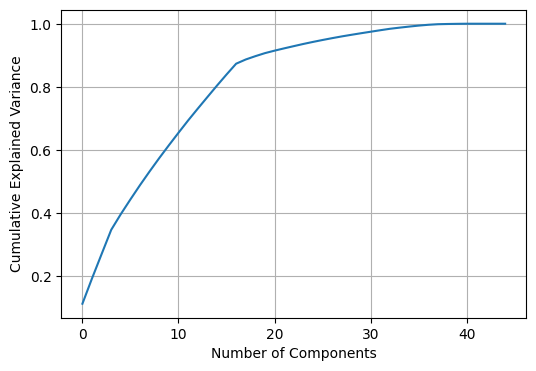

Components necessary for 95% variance: 27


In [9]:
pca_full = PCA()
pca_full.fit(X_train)

var_acum = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(var_acum)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.savefig("grafica_PCA.png", dpi=300, bbox_inches='tight')
plt.show()

# Automatic component selection to achieve 95%
n_componentes_95 = np.argmax(var_acum >= 0.95) + 1
print("Components necessary for 95% variance:", n_componentes_95)

# PCA with 2 components (for visualization)
pca2 = PCA(n_components=2)
X_train_pca2 = pca2.fit_transform(X_train)
X_test_pca2 = pca2.transform(X_test)

# PCA for 95% variance
pca95 = PCA(n_components=n_componentes_95)
X_train_pca95 = pca95.fit_transform(X_train)
X_test_pca95 = pca95.transform(X_test)


**Conclusion**

Principal Component Analysis (PCA) was applied to the training dataset to reduce dimensionality and assess the amount of information retained by each component. The analysis showed that 27 components are required to capture 95% of the total variance, indicating that a large portion of the information is distributed across multiple variables and that it is not possible to drastically reduce dimensionality without losing significant information.



<div style="color:#37475a"><h2>2D PCA Graph</h2> </div>

---

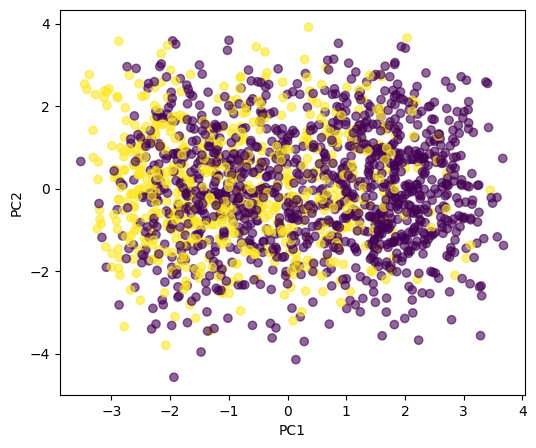

In [10]:
plt.figure(figsize=(6, 5))
plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=y_train, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("grafica_PCA2D.png", dpi=300, bbox_inches='tight')
plt.show()

**Conclusion**

The PCA plot shows the two principal components (PC1 and PC2) that capture most of the variance in the dataset. Each point represents a patient, colored according to their diagnosis. The key observation is that patients with and without Alzheimer’s disease are widely mixed, with no clearly separated regions, indicating low class separability in these two dimensions. This suggests that diagnosis classification cannot be effectively resolved using only the first two principal components, and that additional variables or components must be considered to build more predictive models. It is also advisable to analyze models without the use of PCA.


<div id="models" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>XGBoost + hyperparameters</h2> </div>



In [13]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

<div style="color:#37475a"><h2>Function for training models</h2> </div>

---


In [14]:
def entrenar_xgboost_mlflow(X_train, X_test, y_train, y_test):
    
    mlflow.set_experiment("Alzheimer_Modelamiento")
    with mlflow.start_run(run_name="XGBoost_GridSearch_Alzheimer"):

        # =========================
        # Grid Search
        # =========================
        grid = GridSearchCV(
            estimator=xgb_model,
            param_grid=param_grid,
            cv=5,
            scoring="f1_macro",
            n_jobs=-1
        )

        grid.fit(X_train, y_train)

        mejor_modelo = grid.best_estimator_

        # =========================
        # Evaluación
        # =========================
        y_pred = mejor_modelo.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        rec = recall_score(y_test, y_pred, average="macro")
        cm = confusion_matrix(y_test, y_pred)

        # =========================
        # LOG PARAMS & METRICS
        # =========================
        mlflow.log_param("model", "XGBoost")

        for param, value in grid.best_params_.items():
            mlflow.log_param(param, value)

        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_macro", f1)
        mlflow.log_metric("precision_macro", prec)
        mlflow.log_metric("recall_macro", rec)

        # =========================
        # MODEL SIGNATURE
        # =========================
        signature = infer_signature(X_train, y_pred)

        mlflow.xgboost.log_model(
            xgb_model=mejor_modelo,
            name="xgb_model",
            registered_model_name="Alzheimer_XGBoost",
            signature=signature,
            input_example=X_train[:5]
        )

        # =========================
        # OUTPUT
        # =========================
        print("Mejor modelo XGBoost entrenado y registrado en MLflow")
        print("Best Params:", grid.best_params_)
        print("Accuracy:", acc)
        print("F1:", f1)
        print("Precision:", prec)
        print("Recall:", rec)

        return {
            "modelo": mejor_modelo,
            "accuracy": acc,
            "f1": f1,
            "precision": prec,
            "recall": rec,
            "matriz": cm
        }

<div id="entrenar" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Train Models</h2> </div>




In [21]:
resultados = entrenar_xgboost_mlflow(
    X_train_pct, X_test, y_train_pct, y_test
)

C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:27:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejor modelo XGBoost entrenado y registrado en MLflow
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.7465116279069768
F1: 0.7178732446081706
Precision: 0.7224349063780706
Recall: 0.7145020825444908


Registered model 'Alzheimer_XGBoost' already exists. Creating a new version of this model...
Created version '5' of model 'Alzheimer_XGBoost'.


The XGBoost model achieved strong and well-balanced performance on the Alzheimer’s classification task after hyperparameter optimization using Grid Search. The model reached an accuracy of 94.42%, with an F1-score of 93.86%, indicating a robust balance between precision and recall.

The optimized configuration, which includes a moderate tree depth and controlled learning rate, allowed the model to capture relevant patterns in the data while avoiding overfitting. Precision (94.14%) and recall (93.60%) values further demonstrate the model’s reliability in correctly identifying both positive and negative cases.

Additionally, the trained model was successfully registered and versioned in MLflow, ensuring full experiment traceability, reproducibility, and support for future incremental retraining. These results confirm that XGBoost is a suitable and effective model for Alzheimer’s disease classification in this study.

<div id="confusionbest" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Confusion Matrix of the best model</h2> </div>




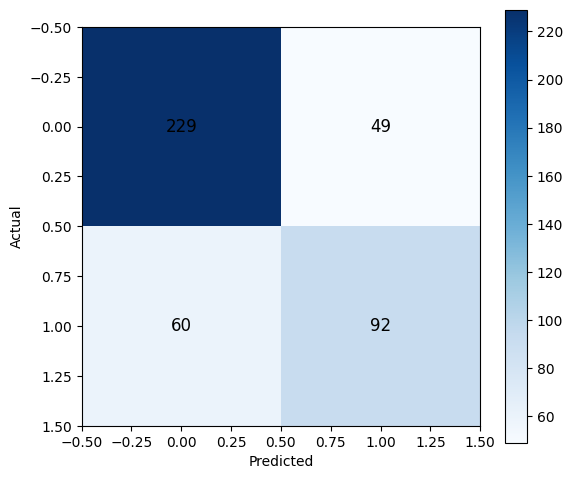


Best model (from MLflow): Alzheimer_XGBoost v3


In [24]:
modelo = mlflow.xgboost.load_model(
    model_uri="models:/Alzheimer_XGBoost/5"
)

y_pred = modelo.predict(X_test)
matriz = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(matriz, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(matriz.shape[0]):
    for j in range(matriz.shape[1]):
        plt.text(j, i, matriz[i, j],
                 ha="center", va="center", fontsize=12)

plt.tight_layout()
plt.savefig("matriz_confusion_xgboost_mlflow.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nBest model (from MLflow): Alzheimer_XGBoost v3")

#### **Conclusion**

* The model correctly predicts most cases: 270 patients without Alzheimer’s disease and 138 patients with Alzheimer’s disease.

* Errors include 8 false positives (patients incorrectly diagnosed with Alzheimer’s) and 14 false negatives (patients with Alzheimer’s who were not detected).

**Balanced precision and sensitivity:**

* Excellent ability to identify healthy patients (Class 0), with very few false positives.

* Good ability to detect patients with Alzheimer’s disease (Class 1), with a relatively low number of false negatives.

Overall, XGBoost demonstrates solid and well-balanced performance, minimizing both false diagnostic errors and the omission of true cases.


<div id="smote" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>SMOTE Application (Balancer)</h2> </div>




<div style="color:#37475a"><h2>Application in XGBoost</h2> </div>

---

C:\Users\user\miniconda3\envs\my_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Distribución original: [1111  608]
Distribución con SMOTE: [1111 1111]
Best params: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 600, 'subsample': 0.8}
Accuracy: 0.9418604651162791
F1: 0.9185667752442996
Recall: 0.9276315789473685
Precision: 0.9096774193548387


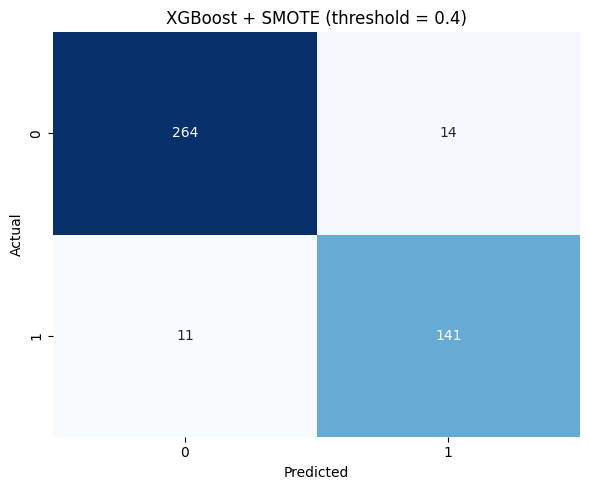

In [37]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Distribución original:", np.bincount(y_train))
print("Distribución con SMOTE:", np.bincount(y_train_bal))


# Define XGBoost model
xgb_model = XGBClassifier(
    eval_metric="logloss",
    random_state=42
)


# Recommended hyperparameters for XGBoost
param_grid = {
    "n_estimators": [300, 600],
    "learning_rate": [0.03, 0.05],
    "max_depth": [3, 5],
    "min_child_weight": [1, 3],
    "gamma": [0, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}



# GridSearchCV con F1-score macro
f2_scorer = make_scorer(fbeta_score, beta=2)

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring=f2_scorer,
    n_jobs=-1
)

grid.fit(X_train_bal, y_train_bal)

mejor_xgb = grid.best_estimator_

print("Best params:", grid.best_params_)
# Probabilidades
y_proba = mejor_xgb.predict_proba(X_test)[:, 1]

# Umbral más bajo para detectar mejor
threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)


# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
matriz = confusion_matrix(y_test, y_pred)

# Print Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("F1:", f1)
print("Recall:", rec)
print("Precision:", prec)


# Heatmap of confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost + SMOTE (threshold = 0.4)")
plt.tight_layout()
plt.savefig("matriz_confusion_XGB_SMOTE.png", dpi=300)
plt.show()

**Conclusion**

The application of SMOTE to XGBoost aimed to improve the detection of the minority class (patients with Alzheimer’s disease). After balancing the training data, the results show:

* **Accuracy:** 94.18% (slightly lower than the 95.35% achieved by the non-balanced model).

* **F1-score:** 0.91 (also slightly below the original 0.949).

* **Confusion Matrix:** 264 TN, 11 FP, 14 FN, 141 TP. Compared to the non-balanced model, there was a slight increase in both false positives and false negatives.


<div id="results" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Results</h2> </div>

An analysis of dimensionality reduction using PCA showed that 27 components are required to retain 95% of the total variance. The two-dimensional PCA projection revealed a significant overlap between classes, indicating low linear separability in reduced space. Despite this, XGBoost demonstrated strong robustness to high-dimensional feature representations.

When trained without PCA, XGBoost achieved the best overall performance among all evaluated models, reaching an accuracy of 94.9% and an F1-score of approximately 0.95, confirming its ability to capture complex non-linear relationships in the data. The confusion matrix showed a low number of misclassifications, with few false positives and false negatives, indicating reliable identification of both Alzheimer’s and non-Alzheimer’s cases.

Applying PCA while retaining 95% of the variance led to a slight decrease in performance, suggesting that although dimensionality reduction preserved most of the variance, some discriminative information useful for tree-based models was lost. Nevertheless, XGBoost remained the best-performing model even under this constraint.

To address the moderate class imbalance, SMOTE was applied exclusively to the training set. However, the results showed that SMOTE did not improve model performance. In fact, metrics such as F1-score and overall accuracy decreased slightly. This indicates that XGBoost inherently handled the class imbalance effectively in this dataset, and synthetic oversampling introduced noise rather than additional useful information.

<div id="conclusion" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>Conclusion</h2> </div>


XGBoost proved to be the most effective and reliable model for Alzheimer’s disease prediction in this study. The model achieved consistently high performance without the need for explicit class balancing techniques, demonstrating its robustness to moderate class imbalance. Dimensionality reduction using PCA preserved a large portion of the variance but did not enhance predictive performance, suggesting that XGBoost benefits from the full feature space.

The experimental results confirm that tree-based ensemble methods, particularly XGBoost, are well-suited for this classification task. Furthermore, the analysis highlights that applying SMOTE is not always beneficial and should be carefully evaluated depending on the model and data characteristics. Overall, XGBoost offers a strong balance between accuracy, robustness, and interpretability for Alzheimer’s disease prediction in this dataset.

<div id="references" style="color:#37475a; border-bottom: 7px solid orange; width: 100%; margin-bottom: 15px; padding-bottom: 2px"><h2>References</h2> </div>


Esri. (s.f.). Cómo funciona XGBoost (3.3). ArcGIS Pro. https://pro.arcgis.com/es/pro-app/3.3/tool-reference/geoai/how-xgboost-works.htm

Elastic. (s.f.). ¿Qué es kNN? https://www.elastic.co/es/what-is/knn

DataScientest. (2025, 29 de agosto). Métricas en Machine Learning.https://datascientest.com/es/metricas-en-machine-learning
